Calculate and plot the time series of the 1st Empirical Orthogonal Function (EOF) of SLP anomalies over the Euro-Atlantic sector (20°-80°N, 90°W-40°E) - i.e. the Hurrel PC-based NAO index (DOI: 10.1029/GM134)

SLP anomalies are calculated for a single ensemble member of global simulations made with GC3.05-PPE as part of UKCP18 (https://catalogue.ceda.ac.uk/uuid/f1a2fc3c120f400396a92f5de84d596a)

The following packages are used in this example: iris, eofs, cartopy.


In [1]:
#Load-in the required packages
import warnings
import numpy as np
import iris
import iris.coord_categorisation
import iris.plot as iplt
import iris.pandas
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import datetime
from eofs.iris import Eof

In [24]:
#Load the target netcdf file using a constraint on ensemble member, lat/lon and time
NA_DJF_constraint=iris.Constraint(
    ensemble_member=1,
    latitude=lambda lats: 20<=lats<=80,longitude=lambda lons: -90<=lons<=40,
    time=lambda t: (t.point.month==2)|(t.point.month==1)|(t.point.month==12)
)

NA_DJF=iris.load('./psl_rcp85_land-gcm_global_60km_01_mon_189912-209911.nc',NA_DJF_constraint)[0]

#print the resulting sub-set of data
print (NA_DJF)

air_pressure_at_sea_level / (hPa)   (time: 600; latitude: 109; longitude: 157)
     Dimension coordinates:
          time                           x              -               -
          latitude                       -              x               -
          longitude                      -              -               x
     Auxiliary coordinates:
          month_number                   x              -               -
          year                           x              -               -
          yyyymm                         x              -               -
     Scalar coordinates:
          ensemble_member: 1
          ensemble_member_id: HadGEM3-GC3.05-r001i1p00000
     Attributes:
          Conventions: CF-1.5
          collection: land-gcm
          contact: ukcpproject@metoffice.gov.uk
          creation_date: 2018-08-25T19:29:18
          description: Sea level pressure
          domain: global
          frequency: mon
          institution: Met Office Hadley Centr

In [25]:
#Add extra attribute data 'season_year' to the netcdf object to define the calendar year associated with each climatological season
iris.coord_categorisation.add_season_year(NA_DJF, 'time', name='season_year')

#Take the temporal mean, grouped by 'season_year'
NA_DJF_annual_seasonal_mean = NA_DJF.aggregated_by(['season_year'], iris.analysis.MEAN)

#Exclude seasonal means shorter than 3 months
three_months_bound = iris.Constraint(time=lambda t: (t.bound[1] - t.bound[0]) > datetime.timedelta(3*28))
NA_DJF_full_season_means = NA_DJF_annual_seasonal_mean.extract(three_months_bound)


In [5]:
#Create simple anomaly field
with warnings.catch_warnings():
    #Ignore warnings created due to the non-contiguous time dimension.
    warnings.simplefilter('ignore', UserWarning)
    NA_DJF_full_season_means_clim = NA_DJF_full_season_means.collapsed('time', iris.analysis.MEAN)

NA_DJF_full_season_means_ano = NA_DJF_full_season_means - NA_DJF_full_season_means_clim

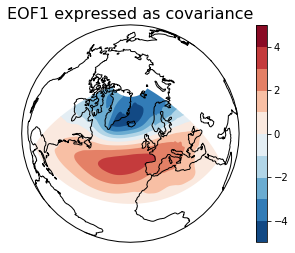

In [9]:
#'EOF 'function handles EOF analysis.
#Square-root of cosine of latitude weights are applied before the computation of EOFs.
solver = Eof(NA_DJF_full_season_means, weights='coslat')

# 1st EOF expressed as the covariance between the 1st PC time series and SLP anomalies.
eof1 = solver.eofsAsCovariance(neofs=1)

# Plot the 1st EOF.
clevs = np.linspace(-5, 5, 11)
proj = ccrs.Orthographic(central_longitude=-20, central_latitude=60)
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_global()
iplt.contourf(eof1[0], levels=clevs, cmap=plt.cm.RdBu_r)
ax.set_title('EOF1 expressed as covariance', fontsize=16)
plt.colorbar()
plt.show()